In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# Hack to get vscode to use my imports (Very weird, it was only getting some of my PYTHONPATHs)
import sys, os
import numpy as np
sys.path.insert(0, os.environ["CSC500_ROOT_PATH"] + "/csc500-notebooks/utils")


In [83]:
# Example snippets for posterity
# g_index

# g.columns
# g[["source_val_label_accuracy", "target_val_label_accuracy", "total_experiment_time_secs"]]
# g.columns
# g.index

# Grouping by parameters (minus seed) gives us the individual experiments as the groups
# p_group = p.groupby(parameter_columns_minus_seed)

# Can set a multi-index as well
# p_index = p.set_index(parameter_columns_minus_seed)
# p_index

# p["experiment_name"]

# Gett the max of each group
# idx = ["target_val_label_accuracy"].transform(max) == p["target_val_label_accuracy"]

# p_group.count()


# p[idx]

In [84]:
import pandas as pd
import seaborn as sb
import os
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
import copy

print(os.environ["PYTHONPATH"])
from series_utils.tl_1 import tl_1_Helper
from series_utils.tl_2 import tl_2_Helper
from series_utils.tl_3 import tl_3_Helper



from steves_utils.summary_utils import (
    get_experiments_from_path
)

from steves_utils.utils_v2 import (
    get_experiments_base_path
)

/mnt/wd500GB/CSC500/csc500-main/csc500-models:/mnt/wd500GB/CSC500/csc500-main/csc500-utils:/usr/local/lib/python3/dist-packages:/usr/local/lib/python3.6/dist-packages:/usr/local/lib/python3/dist-packages:/usr/local/lib/python3.6/dist-packages:


In [85]:
def set_nice_sb_style():
    matplotlib.rcParams.update({'font.size': 22})
    plt.style.use('seaborn-whitegrid')

def add_value_to_sb_bars(fg):
    # iterate through axes
    for ax in fg.axes.ravel():
        
        ax.tick_params(labelbottom=True)
        
        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)

def add_x_val_to_sb_bars(fg):
    # iterate through axes
    for ax in fg.axes.ravel():
        
        ax.tick_params(labelbottom=True)
        
        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.2)

In [86]:
helper_tl_1 = tl_1_Helper()

# Baseline TL results
Show variance in seeds

In [87]:
def show_tl_1_with_variance():
    p = helper_tl_1.get_all_trials()

    m = pd.melt(p, 
            id_vars=["Transfer", "x_transform"],
            value_name="Accuracy",
            value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
            ])
    matplotlib.rcParams.update({'font.size': 22})
    plt.style.use('seaborn-whitegrid')

    fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                            data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
    fg.set_xlabels('')
    plt.figure(figsize=(15,50))

    set_nice_sb_style()
    add_value_to_sb_bars(fg)
    add_x_val_to_sb_bars(fg)
# show_tl_1_with_variance()

# Baseline TL results by selecting best target accuracy

In [88]:
def show_tl_1_best():
    i = helper_tl_1.get_best_trials()
    m = pd.melt(i, 
            id_vars=["Transfer", "x_transform"],
            value_name="Accuracy",
            value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
            ])

    fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                            data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
    fg.set_xlabels('')
    plt.figure(figsize=(15,50))

    set_nice_sb_style()
    add_value_to_sb_bars(fg)
    add_x_val_to_sb_bars(fg)


# Normalziation analysis
Virtually all datasets suffered in accuracy with normalization applied  
Some datasets are more sensitive to normalization than others.  
Magnitude and Power normalization show nearly identical effects.  
(Below chart shows raw data, one cell down shows a condensed version)

In [89]:

def get_tl_1_normalization_results():
    t = helper_tl_1.get_best_trials()
    t = t.pivot(index=["Transfer"], columns=["x_transform"], values=["Source Val Accuracy", "Target Val Accuracy"])
    # print(t.columns)
    t["Source Mag Delta"]   =    t[("Source Val Accuracy", "unit_mag")] - t[("Source Val Accuracy", "None")]
    t["Source Power Delta"] =    t[("Source Val Accuracy", "unit_power")] - t[("Source Val Accuracy", "None")]
    t["Target Mag Delta"] =    t[("Target Val Accuracy", "unit_mag")] - t[("Target Val Accuracy", "None")]
    t["Target Power Delta"] =    t[("Target Val Accuracy", "unit_power")] - t[("Target Val Accuracy", "None")]
    t = t.sort_values("Target Mag Delta")

    return t


In [90]:
def show_tl_1_normalization_deltas():
    tt = get_tl_1_normalization_results()
    tt.columns = tt.columns.droplevel(1)
    tt = tt[["Source Mag Delta", "Source Power Delta", "Target Mag Delta", "Target Power Delta"]]
    tt = tt.reset_index()
    tt = tt.round(3)

    fig, ax = plt.subplots(1)
    fig.set_size_inches(10,5)

    # For the alternating row colors
    z = np.zeros([len(tt.index), len(tt.columns)], dtype=object)
    z[1::2] = "#DCDCDC"
    z[0::2] = "white"

    tab = ax.table(
        cellText=tt.values, colLabels=tt.columns, 
        loc='best', cellLoc='left', 
        colColours=[(.6, .6, .6)] * 10, cellColours=z,
        colWidths=[0.1]*5
    )
    # tab = ax.table(cellText=tt.values, colLabels=tt.columns, )
    ax.set_axis_off()
    tab.auto_set_font_size(True)
    tab.set_fontsize(20)
    # tab.scale(1.5, 2)
    tab.scale(5, 5)
    # fig.set_tight_layout(True)

    from matplotlib.font_manager import FontProperties

    for (row, col), cell in tab.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# Analysis of packet isolation
NB: I called this "framing" in the code.  
Isolating packets reduces the number of samples in the ORACLE datasets from 10k to 2k.  
Experiments with the dataset ORACLE.limited are using 2k examples from non-isolated ORACLE (this acts as a control)  


## CORES
CORES->ORACLE sees ~15% boost in target accuracy when isolating packets  
ORACLE->CORES sees a ~10% reduction in target accuracy, but a ~30% boost in source accuracy.  
I do not have a great explanation for this.

In [91]:
def show_tl_1_oracle_to_cores_all():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "cores->oracle.run1") | (t["Transfer"] == "cores->oracle.run1.limited") | (t["Transfer"] == "cores->oracle.run1.framed")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                                col_order=["cores->oracle.run1", "cores->oracle.run1.limited", "cores->oracle.run1.framed"]
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

def show_tl_1_cores_to_oracle_all():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "oracle.run1->cores") | (t["Transfer"] == "oracle.run1.limited->cores") | (t["Transfer"] == "oracle.run1.framed->cores")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                                col_order=["oracle.run1->cores","oracle.run1.limited->cores","oracle.run1.framed->cores"]
                        )
        fg.set_xlabels('')
        # plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)


# show_tl_1_oracle_to_cores_all()
# show_tl_1_cores_to_oracle_all()

## WISIG
In general WISIG performs worse than CORES when transfer learning with ORACLE (in either direction).  
We see effects similar to CORES, in that WISIG->ORACLE target accuracy is boosted by packet isolation, and ORACLE->WISIG target accuracy suffers slightly, but source accuracy is boosted immensely.

In [92]:
def show_tl_1_oracle_to_wisig_all():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "wisig->oracle.run1") | (t["Transfer"] == "wisig->oracle.run1.limited") | (t["Transfer"] == "wisig->oracle.run1.framed")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                                col_order=["wisig->oracle.run1", "wisig->oracle.run1.limited", "wisig->oracle.run1.framed"]
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)


def show_tl_1_wisig_to_oracle_all():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "oracle.run1->wisig") | (t["Transfer"] == "oracle.run1.limited->wisig") | (t["Transfer"] == "oracle.run1.framed->wisig")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=3, edgecolor = "black",
                                col_order=["oracle.run1->wisig","oracle.run1.limited->wisig","oracle.run1.framed->wisig"]
                        )


        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

# Effects of combining WISIG and CORES for TL
We see if combining WISIG and CORES will boost TL performance.  
The theory behind this is that a greater number and diversity of examples may train better.  
  
Results show that when combining wisig and oracle, accuracy is the average between the two datasets.  
Put another way, accuracy is boosted from the perspective of WISIG only, and degraded from the persepective of CORES only.

In [93]:
def show_tl_2():
        helper_tl_2 = tl_2_Helper()

        i = helper_tl_2.get_best_trials()
        m = pd.melt(i, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=2, edgecolor = "black")
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

#######

def show_tl_1_cores_to_oracle_framed():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "cores->oracle.run1.framed") | (t["Transfer"] == "oracle.run1.framed->cores")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=2, edgecolor = "black",
                                col_order=["cores->oracle.run1.framed", "oracle.run1.framed->cores"]
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)


def show_tl_1_wisig_to_oracle_framed():
        t = helper_tl_1.get_best_trials()
        t = t[(t["Transfer"] == "wisig->oracle.run1.framed") | (t["Transfer"] == "oracle.run1.framed->wisig")]
        m = pd.melt(t, 
                id_vars=["Transfer", "x_transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x='x_transform', col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=1.5, col_wrap=2, edgecolor = "black",
                                col_order=["wisig->oracle.run1.framed", "oracle.run1.framed->wisig"]
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

# show_tl_2()
# show_tl_1_cores_to_oracle_framed()
# show_tl_1_wisig_to_oracle_framed()

# Analysis of signal shapes (PLACEHOLDER)
- TODO: Analyze signals of the datasets, postulate why WISIG performs worse than cores when ostensibly it's near identical to CORES

# Analysis of tl_3 (Advanced post processing)

In [94]:
helper_tl_3 = tl_3_Helper()

t = helper_tl_3.get_best_trials()

print(t.columns)
print("Available target transforms:", t["target_x_transform"].unique())
print("Available source transforms:", t["source_x_transform"].unique())


/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2
Index(['source_name', 'target_name', 'source_x_transform',
       'target_x_transform', 'experiment_name', 'history', 'dataset_metrics',
       'series_name', 'device', 'lr', 'x_shape', 'n_shot', 'n_query',
       'train_k_factor', 'val_k_factor', 'test_k_factor',
       'torch_default_dtype', 'n_epoch', 'patience', 'criteria_for_best',
       'x_net', 'NUM_LOGS_PER_EPOCH', 'BEST_MODEL_PATH', 'n_way', 'datasets',
       'seed', 'dataset_seed', 'source_test_label_accuracy',
       'source_test_label_loss', 'target_test_label_accuracy',
       'target_test_label_loss', 'Source Val Accuracy',
       'source_val_label_loss', 'Target Val Accuracy', 'target_val_label_loss',
       'total_epochs_trained', 'total_experiment_time_secs', 'confusion',
       'per_domain_accuracy', 'Transfer'],
      dtype='object')
Available target transforms: ['take(200),upsample(25e6)' 'jitter(1),take(200),upsample(25e6)'
 'jitter(10),take(200)

In [95]:
t

,source_name,target_name,source_x_transform,target_x_transform,experiment_name,history,dataset_metrics,series_name,device,lr,...,target_test_label_loss,Source Val Accuracy,source_val_label_loss,Target Val Accuracy,target_val_label_loss,total_epochs_trained,total_experiment_time_secs,confusion,per_domain_accuracy,Transfer
0,cores,oracle.run1.framed,"filter(10e6),take(200)","take(200),upsample(25e6)",tl_3-filterv2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 175219, 'n...",tl_3v2,cuda,0.0001,...,1.462497,0.999429,0.006738,0.566862,1.461652,12,3390.758717,"{'C_5': {'26': {'26': 24}, '7': {'7': 32}, '56...","{'C_5': {'accuracy': 0.9994762569832403, 'sour...",cores->oracle.run1.framed
1,cores,oracle.run1.framed,"jitter(1),filter(10e6),take(200)","jitter(1),take(200),upsample(25e6)",tl_3-jitter1v2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 175200, 'n...",tl_3v2,cuda,0.0001,...,1.349591,0.998894,0.024875,0.550749,1.347984,14,4348.330611,"{'C_3': {'43': {'43': 128}, '9': {'9': 150}, '...","{'C_3': {'accuracy': 0.9989098837209303, 'sour...",cores->oracle.run1.framed
2,cores,oracle.run1.framed,"jitter(10),filter(10e6),take(200)","jitter(10),take(200),upsample(25e6)",tl_3-jitter10v2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7], 'trai...","{'source': {'train': {'n_unique_x': 175189, 'n...",tl_3v2,cuda,0.0001,...,1.801961,0.998181,0.010985,0.496029,1.807957,7,1110.935873,"{'C_3': {'43': {'43': 128}, '9': {'9': 150}, '...","{'C_3': {'accuracy': 0.9992732558139535, 'sour...",cores->oracle.run1.framed
3,cores,oracle.run1.framed,"jitter(5),filter(10e6),take(200)","jitter(5),take(200),upsample(25e6)",tl_3-jitter5v2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9, ...","{'source': {'train': {'n_unique_x': 175168, 'n...",tl_3v2,cuda,0.0001,...,1.506992,0.999321,0.011541,0.477181,1.511394,13,1990.239567,"{'C_2': {'21': {'21': 120}, '4': {'4': 130}, '...","{'C_2': {'accuracy': 0.9994673295454546, 'sour...",cores->oracle.run1.framed
4,cores,oracle.run1.framed,take(200),"take(200),upsample(25e6)",tl_3Av2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9],...","{'source': {'train': {'n_unique_x': 175135, 'n...",tl_3v2,cuda,0.0001,...,1.563632,0.999251,0.010492,0.576497,1.563455,9,1390.660190,"{'C_3': {'43': {'43': 128}, '9': {'9': 150}, '...","{'C_3': {'accuracy': 0.9992732558139535, 'sour...",cores->oracle.run1.framed
5,cores,oracle.run1.framed,"unit_mag,filter(10e6),take(200)","unit_mag,take(200),upsample(25e6)",tl_3-filterv2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6], 'train_l...","{'source': {'train': {'n_unique_x': 175171, 'n...",tl_3v2,cuda,0.0001,...,1.939295,0.998570,0.009667,0.354297,1.937104,6,1713.017433,"{'C_2': {'21': {'21': 120}, '4': {'4': 130}, '...","{'C_2': {'accuracy': 0.9985795454545454, 'sour...",cores->oracle.run1.framed
6,cores,oracle.run1.framed,"unit_mag,jitter(1),filter(10e6),take(200)","unit_mag,jitter(1),take(200),upsample(25e6)",tl_3-jitter1v2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5, 6, 7, 8, 9],...","{'source': {'train': {'n_unique_x': 175160, 'n...",tl_3v2,cuda,0.0001,...,2.115361,0.999393,0.072875,0.375000,2.092987,9,2839.061502,"{'C_4': {'42': {'42': 32}, '0': {'0': 80}, '1'...","{'C_4': {'accuracy': 0.998877245508982, 'sourc...",cores->oracle.run1.framed
7,cores,oracle.run1.framed,"unit_mag,jitter(10),filter(10e6),take(200)","unit_mag,jitter(10),take(200),upsample(25e6)",tl_3-jitter10v2:cores -> oracle.run1.framed,"{'epoch_indices': [1, 2, 3, 4, 5], 'train_labe...","{'source': {'train': {'n_unique_x': 175169, 'n...",tl_3v2,cuda,0.0001,...,1.654898,0.996718,0.015414,0.400553,1.659268,5,888.323892,"{'C_3': {'43': {'43': 128}, '9': {'9': 150}, '...","{'C_3': {'accuracy': 0.9983648255813954, 'sour...",cores->oracle.run1.framed
8,cores,oracle.run1.framed,"unit_ma

In [96]:
"""
Will dowselect, selects all normalization schemes
"""
def get_tl_3_trials(df, source, source_transform, target, target_transform):
    if source_transform != None:
        s_t = [
            "unit_mag,"+source_transform,
            "unit_power,"+source_transform,
            source_transform
        ]

    if target_transform != None:
        t_t = [
            "unit_mag,"+target_transform,
            "unit_power,"+target_transform,
            target_transform
        ]

    idx = df.apply(lambda x: True, axis=1)
    
    if source != None:
        idx = idx & df.apply(
            lambda x:
                source in x["source_name"],
            axis=1
        )
    if target != None:
        idx = idx & df.apply(
            lambda x:
                target in x["target_name"],
            axis=1
        )
    if source_transform != None:
        idx = idx & df.apply(
            lambda x:
                x["source_x_transform"] in s_t,
            axis=1
        )
    if target_transform != None:
        idx = idx & df.apply(
            lambda x:
                x["target_x_transform"] in t_t,
            axis=1
        )

    return df[idx].copy(deep=True)

def make_transform_string(row):
    if "unit_mag" in row["source_x_transform"]: return "unit_mag"
    if "unit_power" in row["source_x_transform"]: return "unit_power"
    else: return "None"

In [97]:
def show_tl_3_upsample_and_slice():
        t = helper_tl_3.get_best_trials()
        t_A = get_tl_3_trials(t, "oracle.run1.framed", "take(200),upsample(25e6)", "cores", "take(200)")
        t_A["Transfer"] = "oracle.run1.framed->cores (upsample and slice)"
        t_A["Transform"] = t_A.apply(make_transform_string, axis=1)

        t_B = get_tl_3_trials(t, "cores", "take(200)", "oracle.run1.framed", "take(200),upsample(25e6)")
        t_B["Transfer"] = "cores->oracle.run1.framed (upsample and slice)"
        t_B["Transform"] = t_B.apply(make_transform_string, axis=1)

        t_f = pd.concat([t_A, t_B])

        m = pd.melt(t_f, 
                id_vars=["Transfer", "Transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x="Transform", col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black",
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)


In [98]:
def show_tl_3_upsample_and_slice_and_filter():
        t = helper_tl_3.get_best_trials()
        t_A = get_tl_3_trials(t, "oracle.run1.framed", "take(200),upsample(25e6)", "cores", "filter(10e6),take(200)")
        t_A["Transfer"] = "oracle.run1.framed->cores (upsample, slice, filter)"
        t_A["Transform"] = t_A.apply(make_transform_string, axis=1)

        t_B = get_tl_3_trials(t, "cores", "filter(10e6),take(200)", "oracle.run1.framed", "take(200),upsample(25e6)")
        t_B["Transfer"] = "cores->oracle.run1.framed (upsample, slice, filter)"
        t_B["Transform"] = t_B.apply(make_transform_string, axis=1)

        t_f = pd.concat([t_A, t_B])

        m = pd.melt(t_f, 
                id_vars=["Transfer", "Transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x="Transform", col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black",
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

In [99]:
def show_tl_3_upsample_slice_filter_jitter_1():
        t = helper_tl_3.get_best_trials()
        t_A = get_tl_3_trials(t, "oracle.run1.framed", "jitter(1),take(200),upsample(25e6)", "cores", "jitter(1),filter(10e6),take(200)")
        t_A["Transfer"] = "oracle.run1.framed->cores (upsample, slice, filter, jitter(1))"
        t_A["Transform"] = t_A.apply(make_transform_string, axis=1)

        t_B = get_tl_3_trials(t, "cores", "jitter(1),filter(10e6),take(200)", "oracle.run1.framed", "jitter(1),take(200),upsample(25e6)")
        t_B["Transfer"] = "cores->oracle.run1.framed (upsample, slice, filter, jitter(1))"
        t_B["Transform"] = t_B.apply(make_transform_string, axis=1)

        t_f = pd.concat([t_A, t_B])

        m = pd.melt(t_f, 
                id_vars=["Transfer", "Transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x="Transform", col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black",
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

In [100]:
def show_tl_3_upsample_slice_filter_jitter_5():
        t = helper_tl_3.get_best_trials()
        t_A = get_tl_3_trials(t, "oracle.run1.framed", "jitter(5),take(200),upsample(25e6)", "cores", "jitter(5),filter(10e6),take(200)")
        t_A["Transfer"] = "oracle.run1.framed->cores (upsample, slice, filter, jitter(5))"
        t_A["Transform"] = t_A.apply(make_transform_string, axis=1)

        t_B = get_tl_3_trials(t, "cores", "jitter(5),filter(10e6),take(200)", "oracle.run1.framed", "jitter(5),take(200),upsample(25e6)")
        t_B["Transfer"] = "cores->oracle.run1.framed (upsample, slice, filter, jitter(5))"
        t_B["Transform"] = t_B.apply(make_transform_string, axis=1)

        t_f = pd.concat([t_A, t_B])

        m = pd.melt(t_f, 
                id_vars=["Transfer", "Transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x="Transform", col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black",
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

In [101]:
def show_tl_3_upsample_slice_filter_jitter_10():
        t = helper_tl_3.get_best_trials()
        t_A = get_tl_3_trials(t, "oracle.run1.framed", "jitter(10),take(200),upsample(25e6)", "cores", "jitter(10),filter(10e6),take(200)")
        t_A["Transfer"] = "oracle.run1.framed->cores (upsample, slice, filter, jitter(10))"
        t_A["Transform"] = t_A.apply(make_transform_string, axis=1)

        t_B = get_tl_3_trials(t, "cores", "jitter(10),filter(10e6),take(200)", "oracle.run1.framed", "jitter(10),take(200),upsample(25e6)")
        t_B["Transfer"] = "cores->oracle.run1.framed (upsample, slice, filter, jitter(10))"
        t_B["Transform"] = t_B.apply(make_transform_string, axis=1)

        t_f = pd.concat([t_A, t_B])

        m = pd.melt(t_f, 
                id_vars=["Transfer", "Transform"],
                value_name="Accuracy",
                value_vars=[
                "Source Val Accuracy",
                "Target Val Accuracy",
                ])

        fg = sb.catplot(x="Transform", col="Transfer", y='Accuracy', hue='variable', 
                                data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black",
                        )
        fg.set_xlabels('')
        plt.figure(figsize=(15,50))

        set_nice_sb_style()
        add_value_to_sb_bars(fg)
        add_x_val_to_sb_bars(fg)

# Baseline TL results
Transfer learning was done between ORACLE, CORES, and WISIG datasets.  
Each dataset is pre_processed with either unit magnitude, unit power, or no preprocessing at all.  

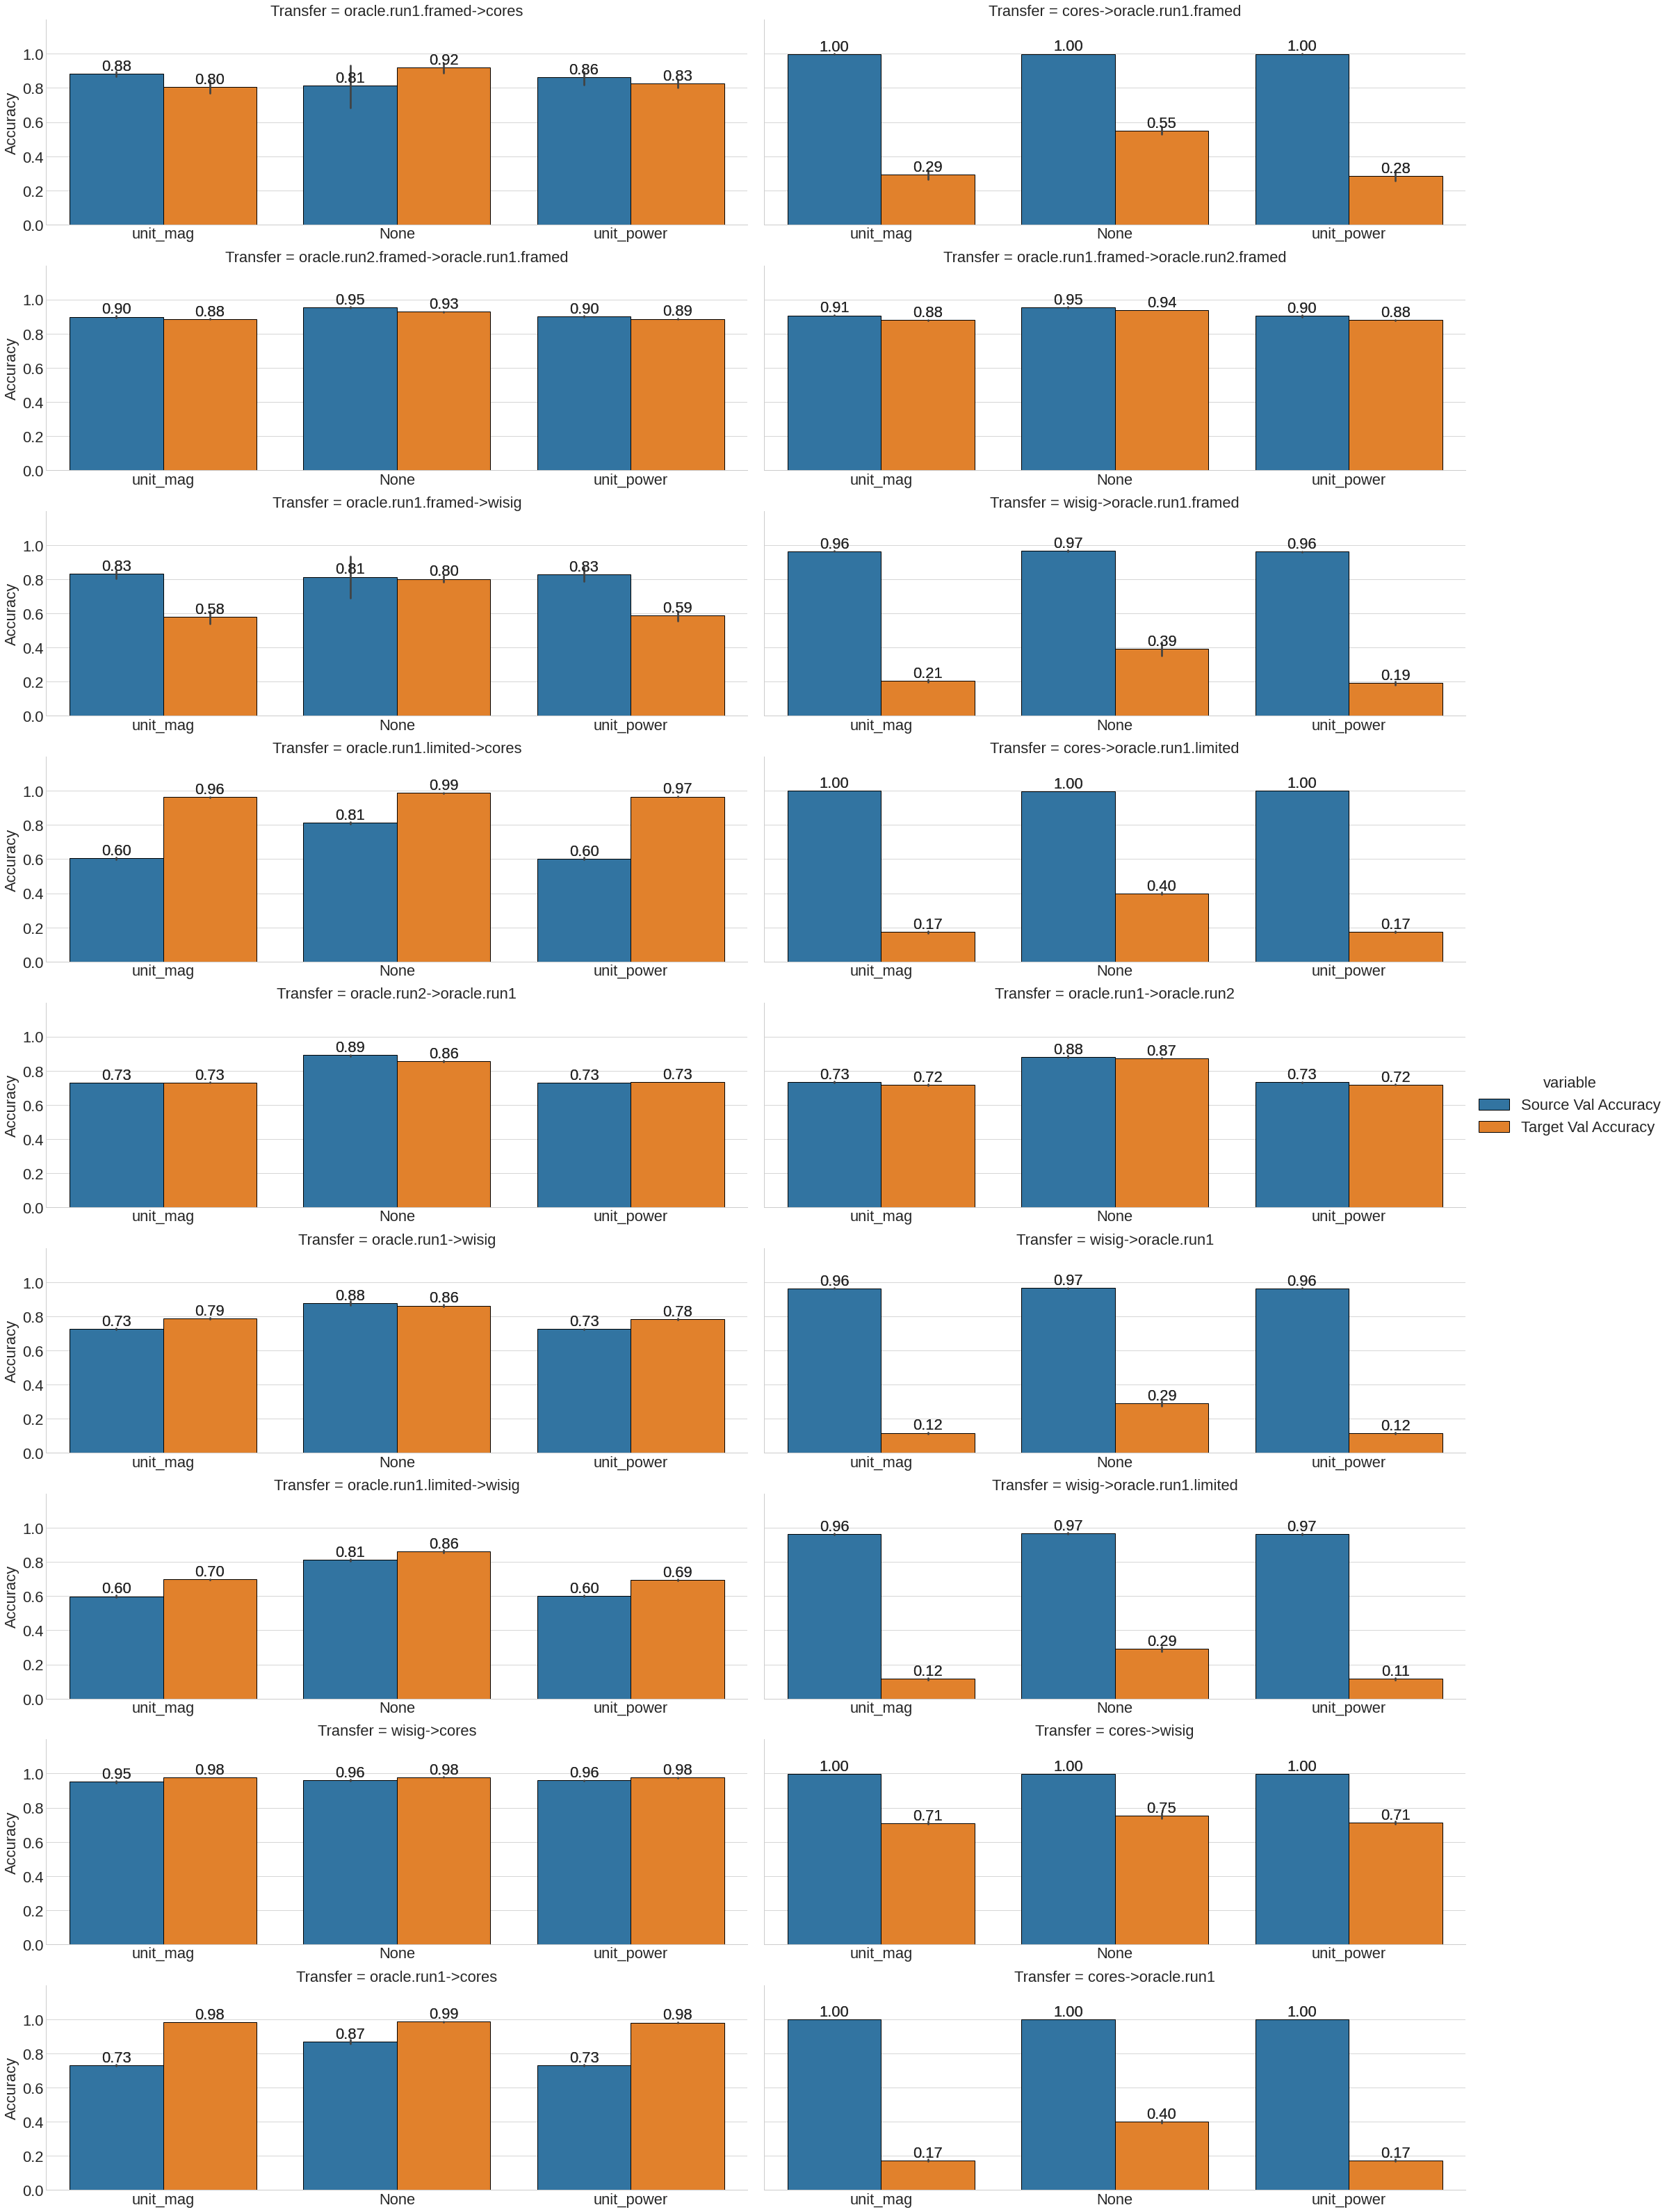

<Figure size 1080x3600 with 0 Axes>

In [102]:
show_tl_1_with_variance()

# Baseline TL conclusions
The black bar indicates std deviation of the trial accuracies. Some datasets are more sensitive than others.  
Going forward, each experiment parameter is conducted with 5 different dataset splits and seeds. The trial with the highest target accuracy is selected

# Baseline TL results by selecting best target accuracy

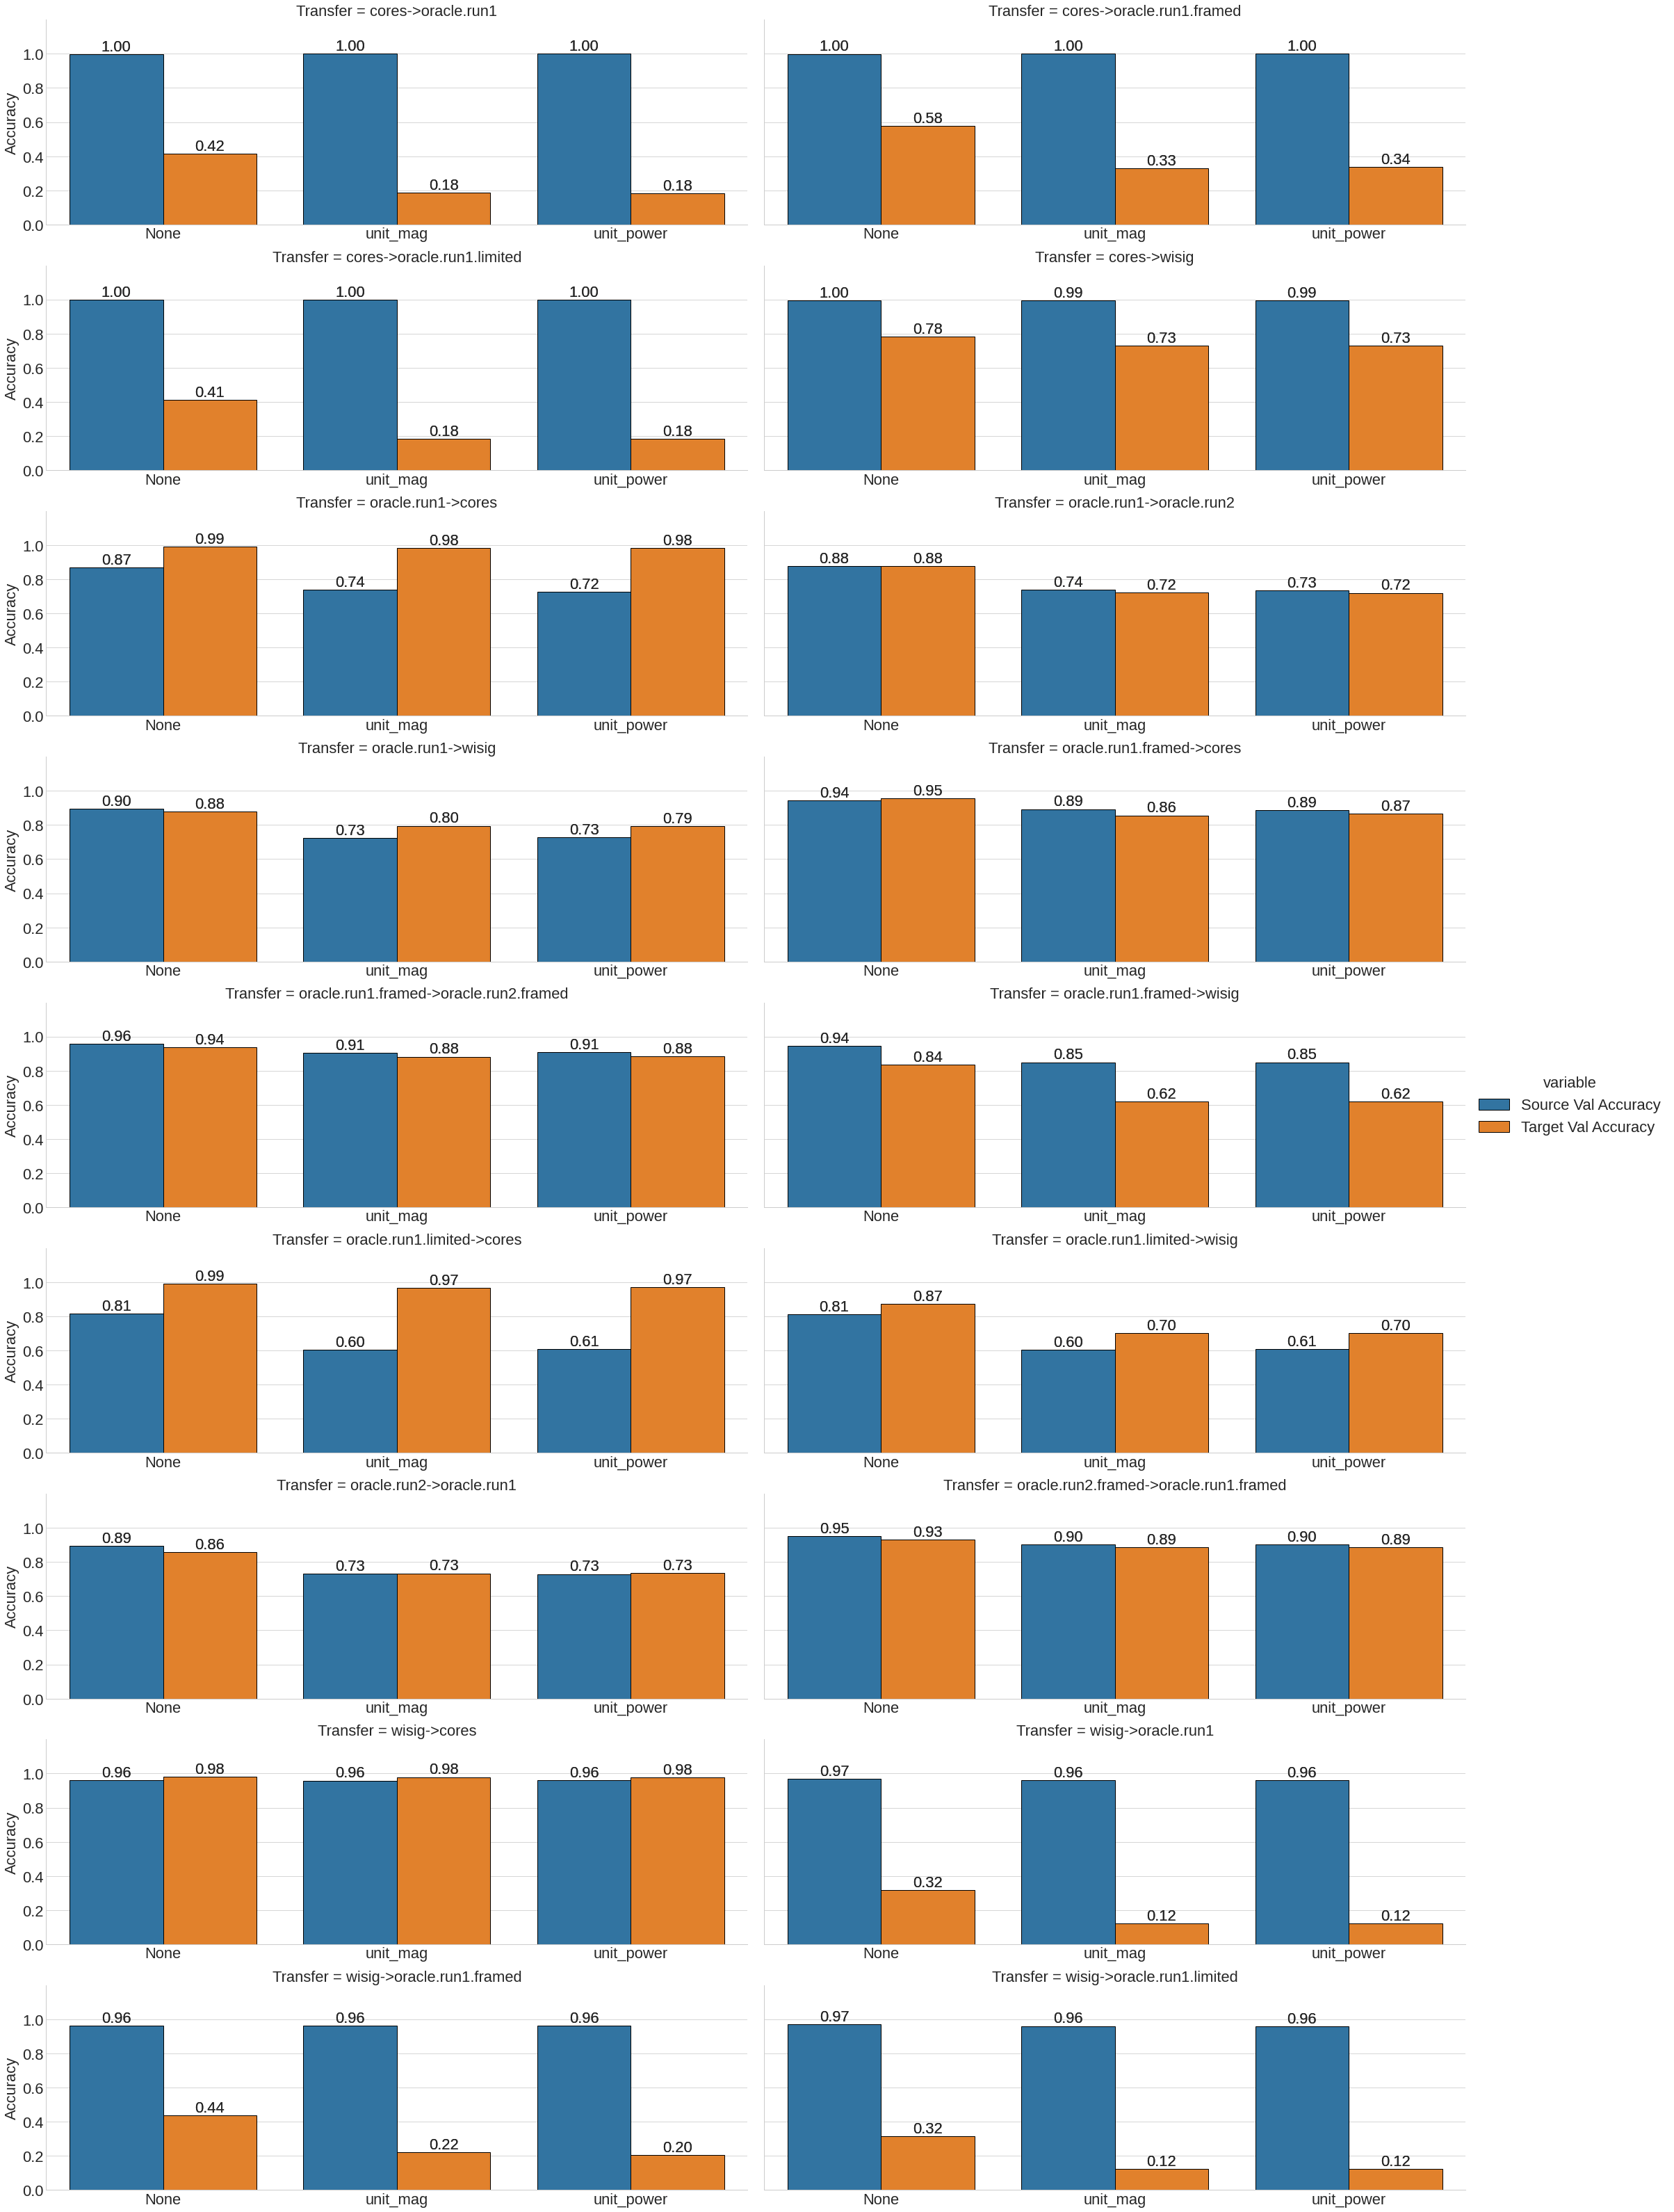

<Figure size 1080x3600 with 0 Axes>

In [103]:
show_tl_1_best()

# Baseline TL by best conclusions
* wisig -> cores achieves very high accuracy regardless of normalization
* cores -> wisig achieves far worse accuracy
* oracle.run1 <-> oracle.run2 regardless of pre-processing achieves near identical results, suggests that the datasets are very similar (will analyze more closely in later section)
* wisig and cores -> oracle achieves varied and typically low accuracy (will analyze more closely in later section)
* Normalization tends to decrease accuracy, will analyze next section

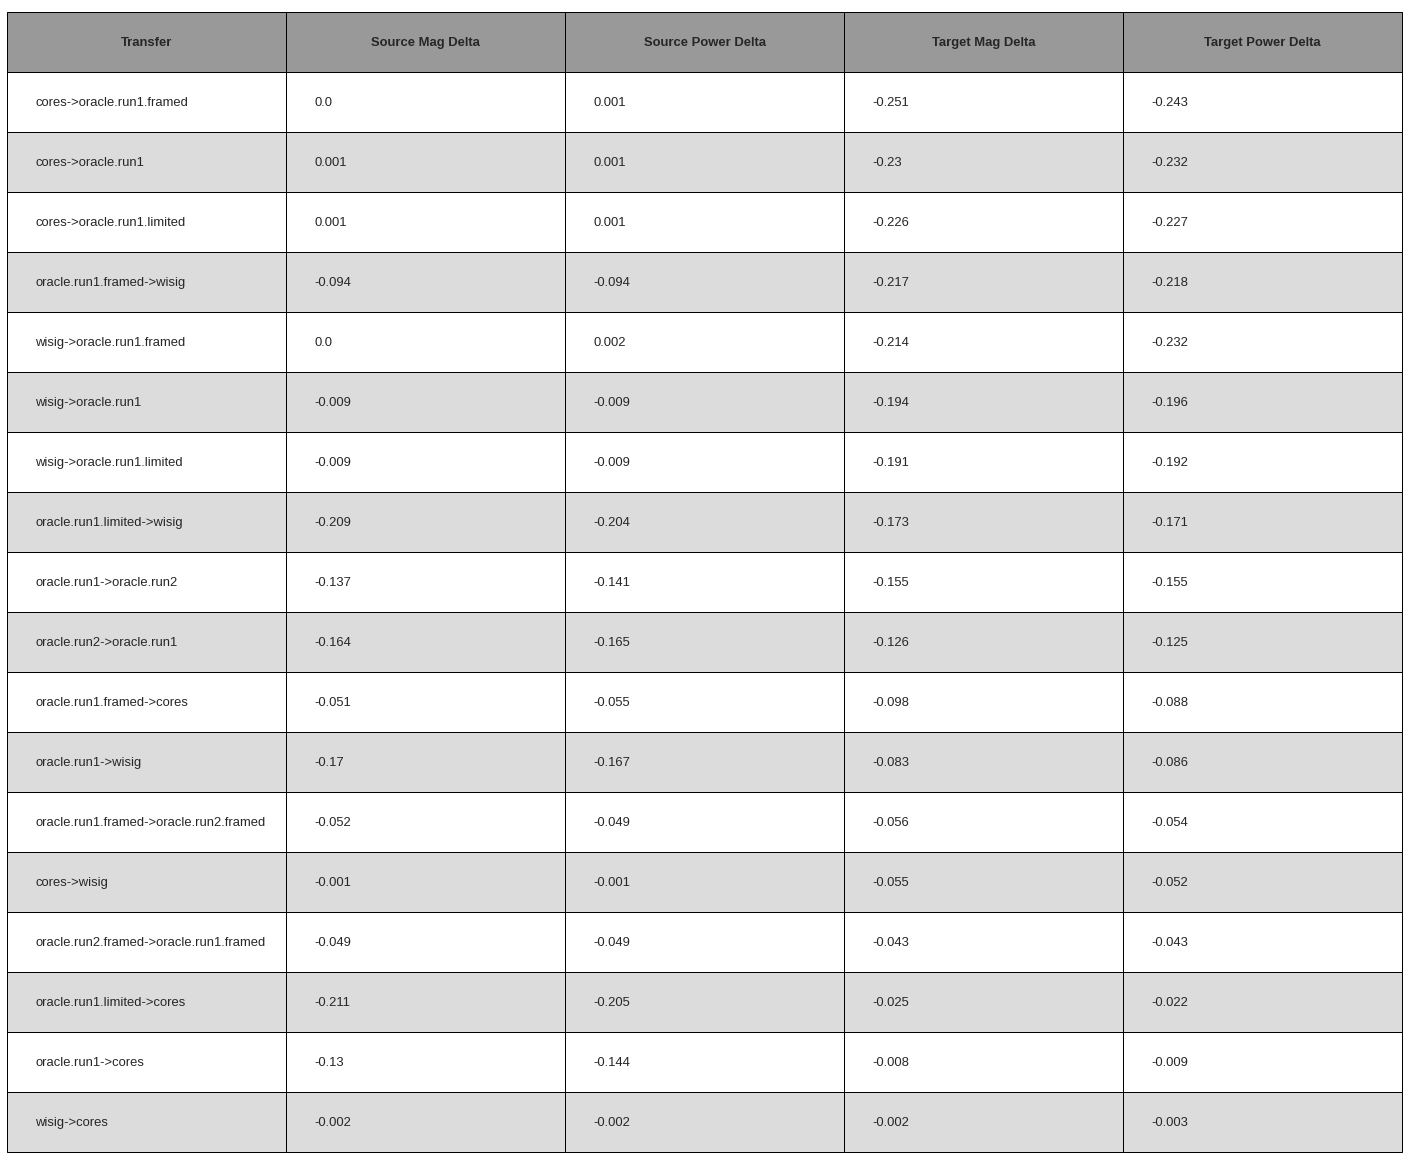

In [104]:
show_tl_1_normalization_deltas()

# Normalization conclusions
* Some datasets are extrememly sensitive to normalization (cores->oracle.framed reduces accuracy by 25% when normalized, oracle.framed -> cores only reduces by 8%)

# Packet Isolation Performance
NB: I called this "framing" in the code.  
Isolating packets reduces the number of samples in the ORACLE datasets from 10k to 2k.  
Experiments with the dataset ORACLE.limited are using 2k examples from non-isolated ORACLE (this acts as a control)  

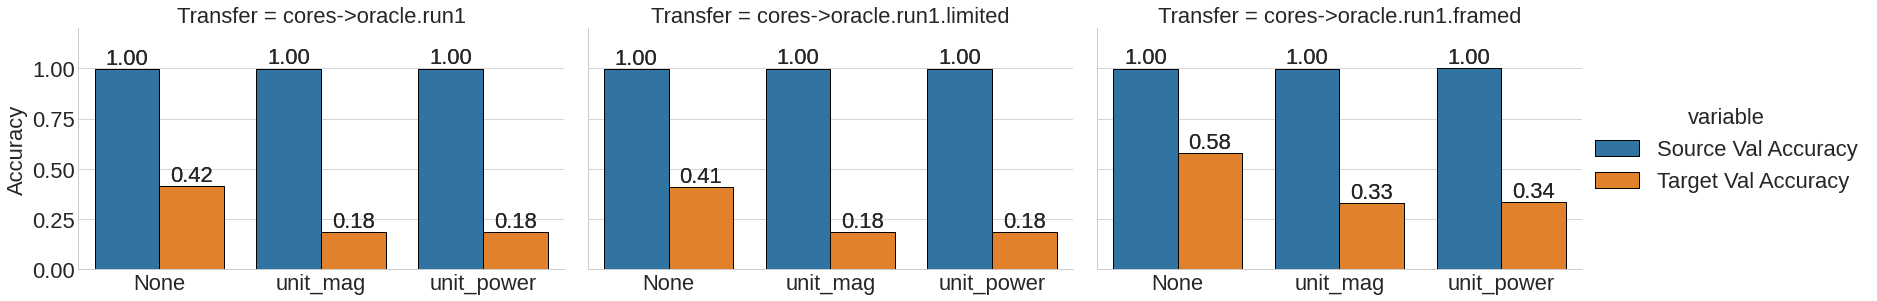

<Figure size 1080x3600 with 0 Axes>

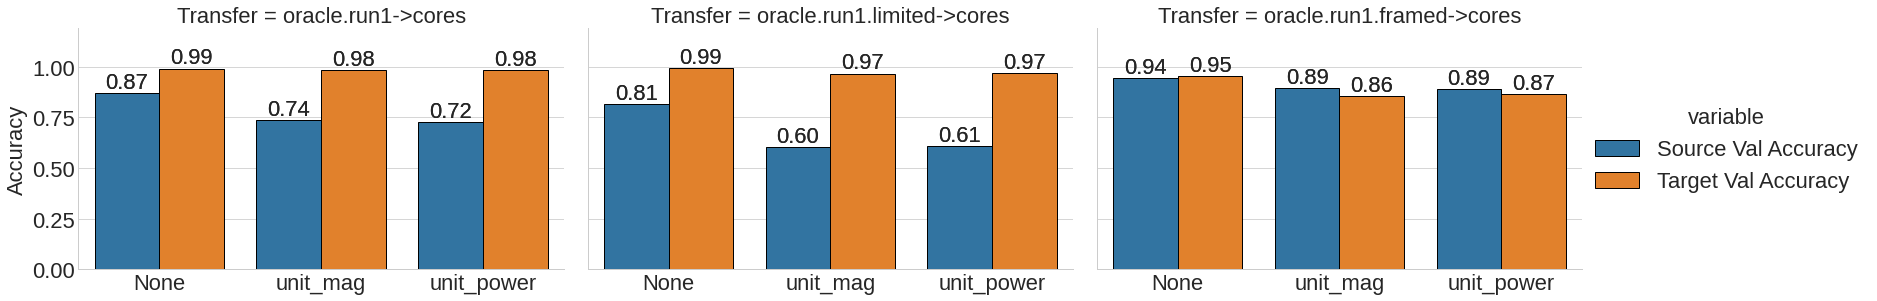

In [105]:
show_tl_1_oracle_to_cores_all()
show_tl_1_cores_to_oracle_all()

## Packet Isolation performance analysis against CORES
CORES->ORACLE sees ~15% boost in target accuracy when isolating packets  
ORACLE->CORES sees a ~10% reduction in target accuracy, but a ~30% boost in source accuracy.  
I do not have a great explanation for why source accuracy increases

## Wisig <-> ORACLE


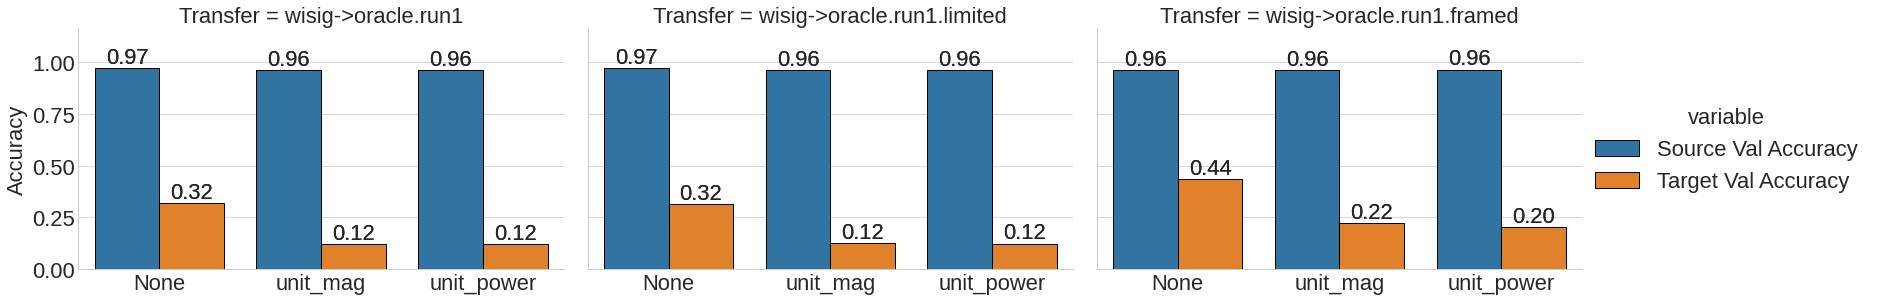

<Figure size 1080x3600 with 0 Axes>

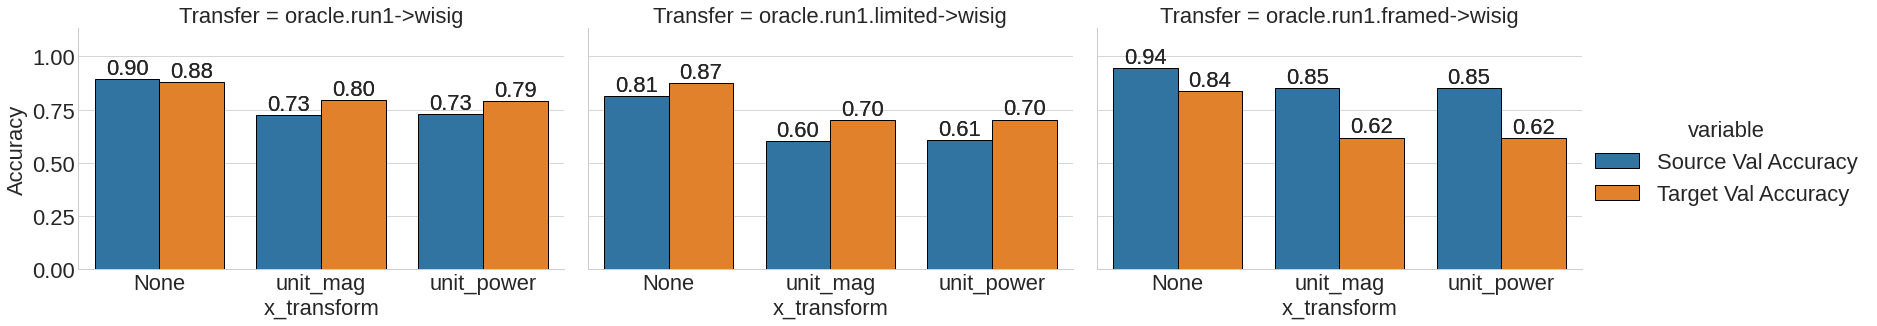

In [106]:
show_tl_1_oracle_to_wisig_all()
show_tl_1_wisig_to_oracle_all()

## WISIG Analysis
In general WISIG performs worse than CORES when transfer learning with ORACLE (in either direction).  
We see effects similar to CORES, in that WISIG->ORACLE target accuracy is boosted by packet isolation, and ORACLE->WISIG target accuracy suffers slightly, but source accuracy is boosted immensely.

# Effects of combining WISIG and CORES for TL
We see if combining WISIG and CORES will boost TL performance.  
The theory behind this is that a greater number and diversity of examples may train better.  

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_2v2


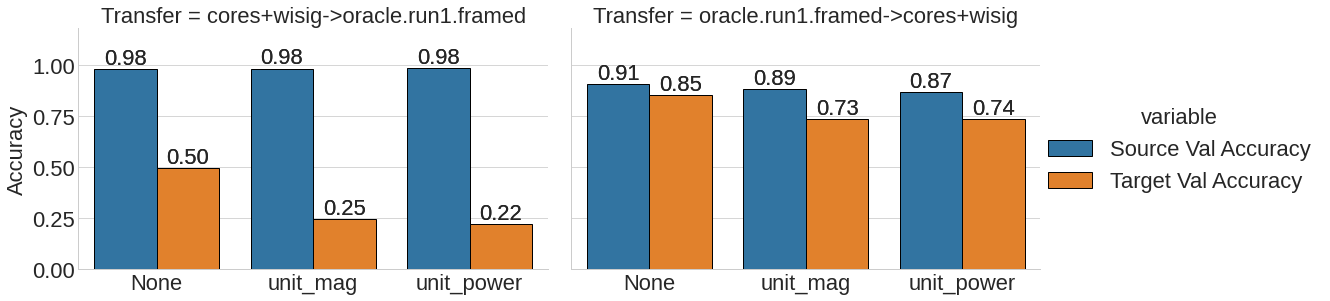

<Figure size 1080x3600 with 0 Axes>

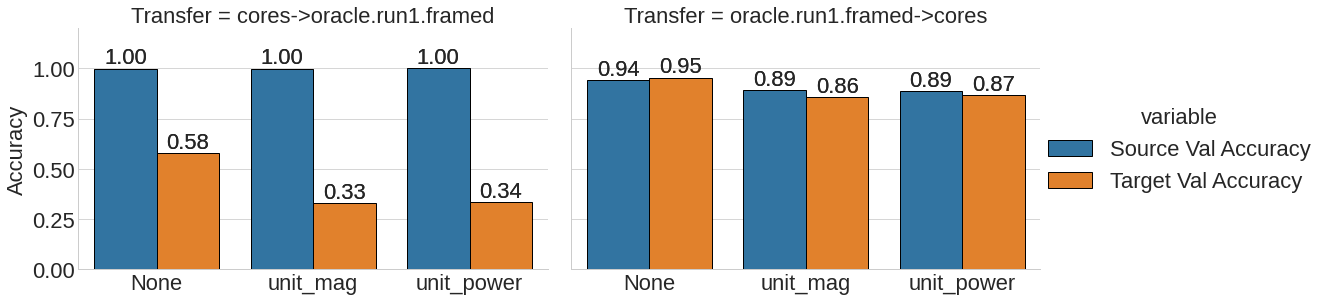

<Figure size 1080x3600 with 0 Axes>

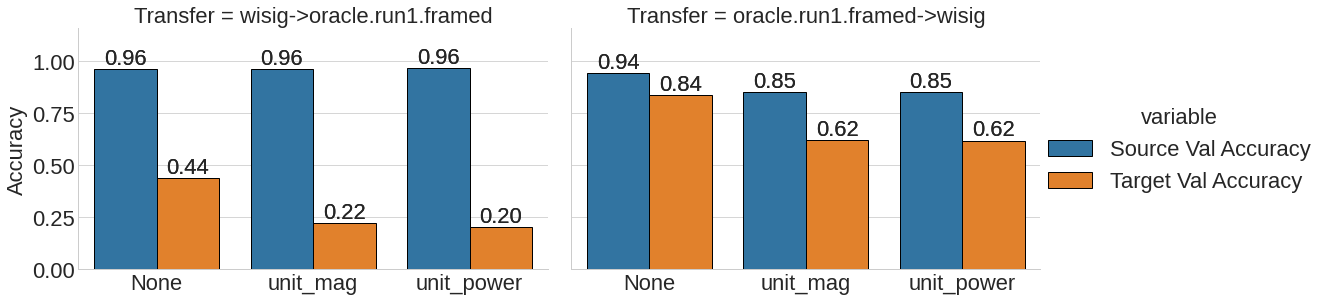

<Figure size 1080x3600 with 0 Axes>

In [107]:
show_tl_2()
show_tl_1_cores_to_oracle_framed()
show_tl_1_wisig_to_oracle_framed()

## Analysis
Results show that when combining wisig and oracle, accuracy is the average between the two datasets.  
Put another way, accuracy is boosted from the perspective of WISIG only, and degraded from the persepective of CORES only.

# Analysis of signal shapes (PLACEHOLDER)
- TODO: Analyze signals of the datasets, postulate why WISIG performs worse than cores when ostensibly it's near identical to CORES

# Looking at the effects of upsampling, jittering, and filtering

### Upsample ORACLE, slice 200 from both CORES and ORACLE

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2


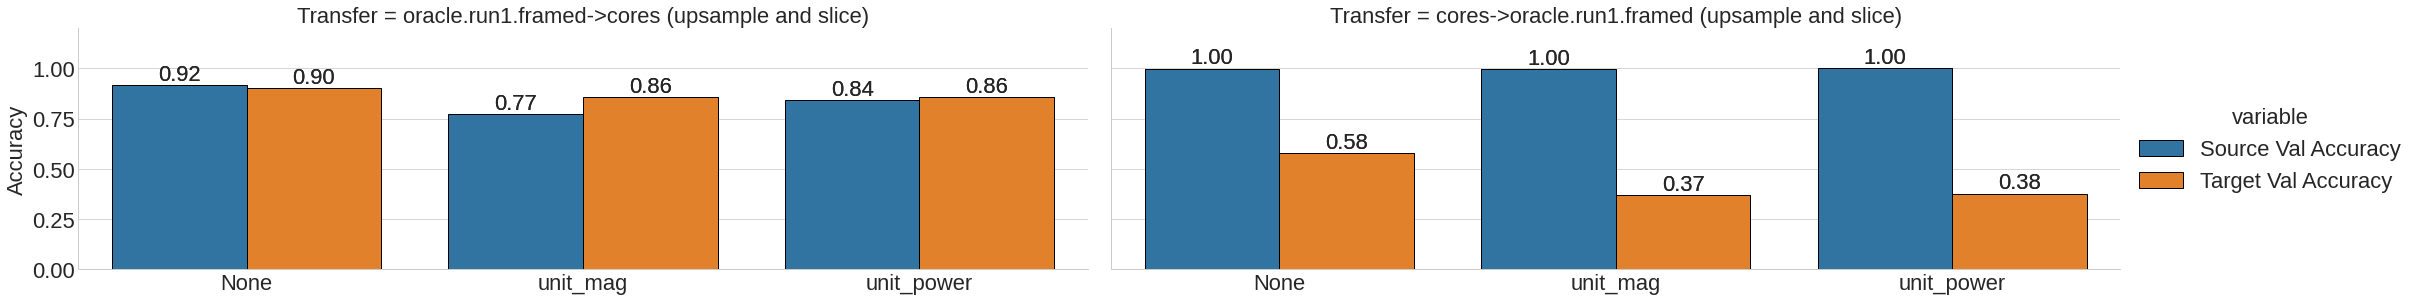

<Figure size 1080x3600 with 0 Axes>

In [108]:
show_tl_3_upsample_and_slice()

### Upsample ORACLE, filter CORES to +/- 10MHz, slice 200 from both CORES and ORACLE

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2


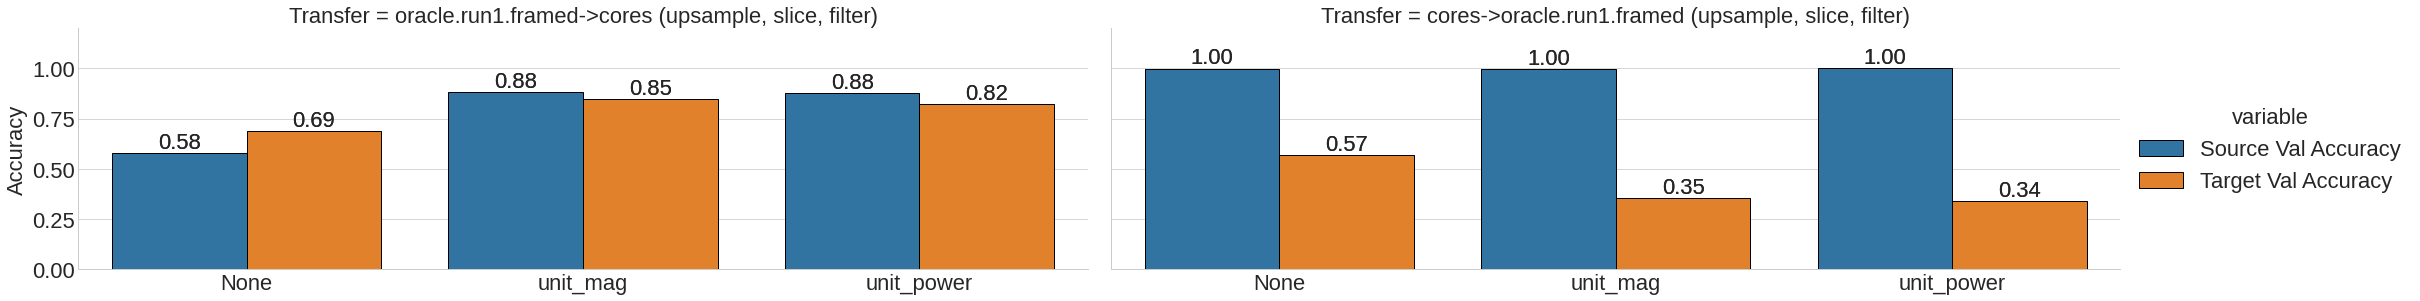

<Figure size 1080x3600 with 0 Axes>

In [109]:
show_tl_3_upsample_and_slice_and_filter()

### Upsample ORACLE, filter CORES to +/- 10MHz, slice 200 from both CORES and ORACLE, apply a jitter with a std deviation of 1

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2


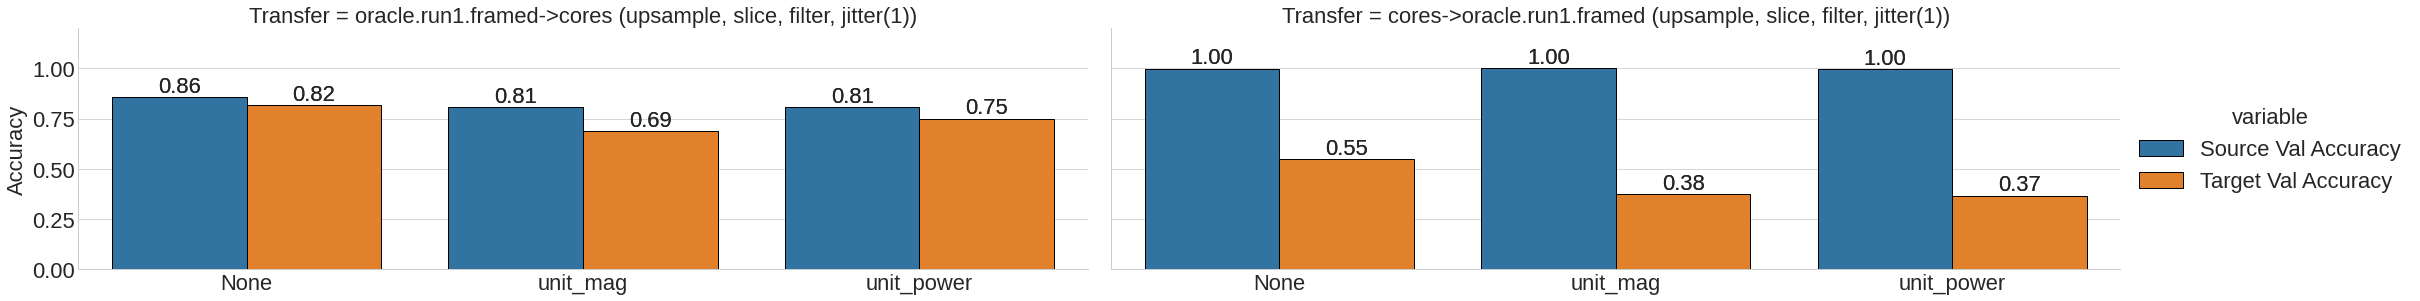

<Figure size 1080x3600 with 0 Axes>

In [110]:
show_tl_3_upsample_slice_filter_jitter_1()

### Upsample ORACLE, filter CORES to +/- 10MHz, slice 200 from both CORES and ORACLE, apply a jitter with a std deviation of 5

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2


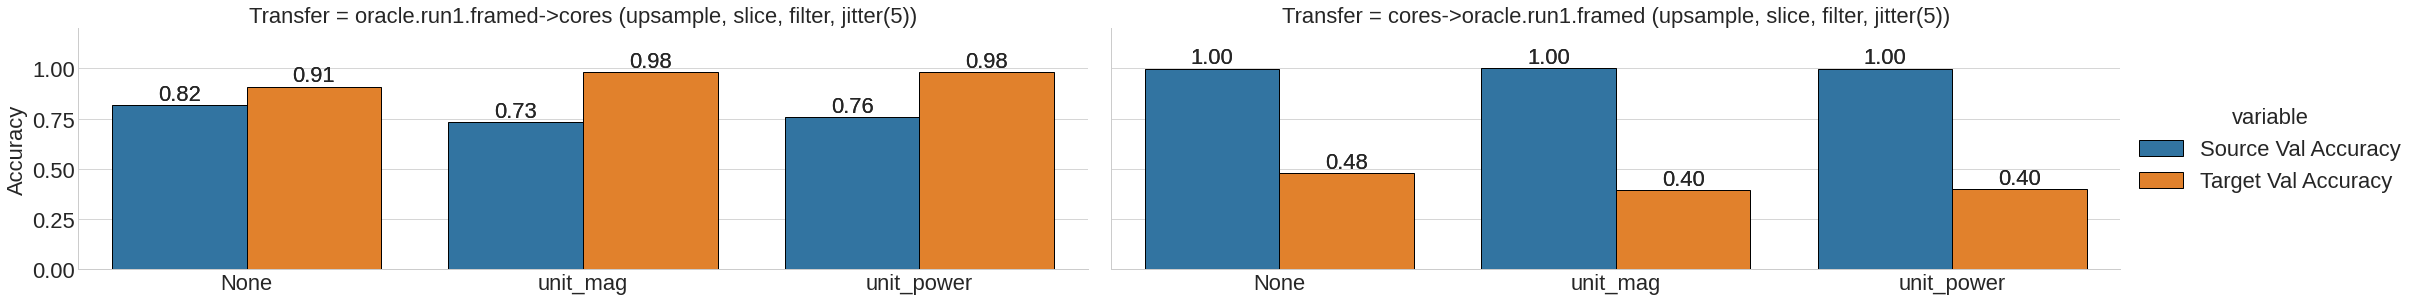

<Figure size 1080x3600 with 0 Axes>

In [111]:
show_tl_3_upsample_slice_filter_jitter_5()

### Upsample ORACLE, filter CORES to +/- 10MHz, slice 200 from both CORES and ORACLE, apply a jitter with a std deviation of 10

/mnt/wd500GB/CSC500/csc500-main/csc500-notebooks/experiments/tl_3v2


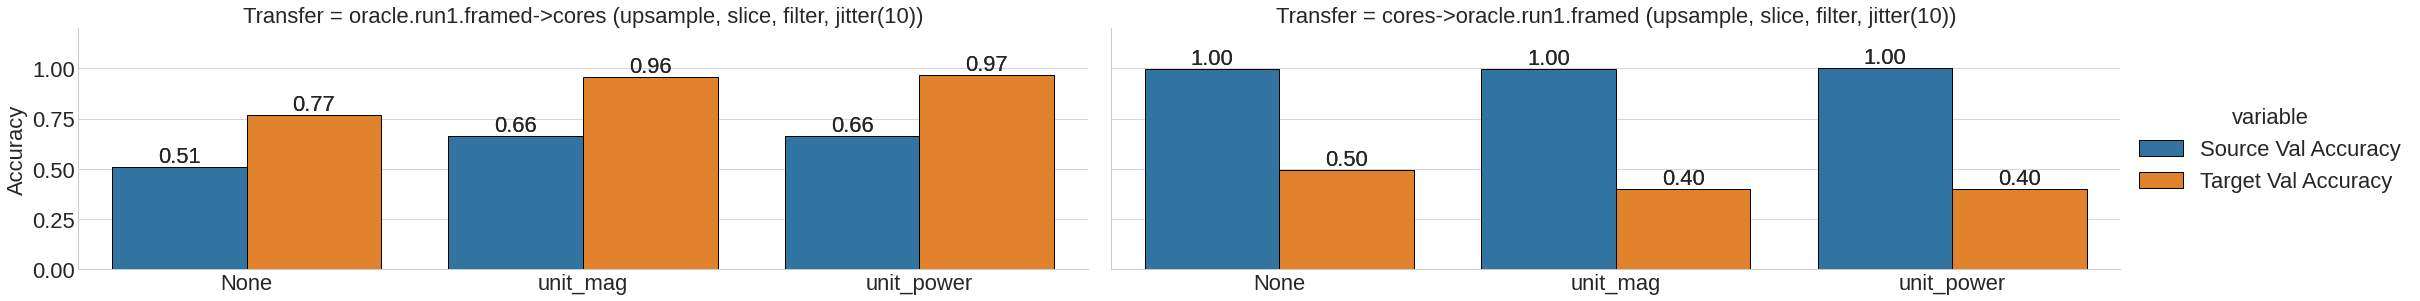

<Figure size 1080x3600 with 0 Axes>

In [112]:
show_tl_3_upsample_slice_filter_jitter_10()